In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd

In [2]:
# Constants (Table 5)
T = 650 +273.15 # K, 650 C
P = 101325 # Pa, 1 atm
y_in = 0.15 # also use 0.45, 0.75, 0.9
F_in = 20 # NmL/min
F_in = F_in/(1e6*60) # mL/s
d_reactor = 7e-3 # m
d_particle = 112.5e-6 # m
rho0_particle = 1693 #kg/m3
eps0_particle = 0.4
ks = 5.95e-7 # m4/kmol-s
# ks = ks/1e3 # m4/mol-s
alpha = 1.65
a = 22.7
b = 0.35
d0_CaO = 69.5e-9 # m 
Dr = 1e-5 # m2/s
eps = 0.5
rho_CaO = 3340 #kg/m3

# Additional constants (from paper or known)
R = 8.314 #J/molK
R = R * 1000 # J/kmolK
zeta = 2.18 # CaCO3:CaO molar volume ratio
MW_CaO = 56.0774 # g/mol, kg/kmol
MW_mayenite = 1386.6 # kg/kmol
H = 0.15 # m 

In [3]:
# Computed constants
S = np.pi*(d_reactor/2)**2 #m2, reactor cross sectional area
Ctot = P/(R*T)
u_in = F_in / S
tau_b = H / u_in
v_CaO = MW_CaO/rho_CaO #m3/kmol
n_CaO = rho0_particle / MW_CaO # kmol/m3

# Dimensionless quantities
DR = Dr * tau_b / H**2
U_in = 1 # Dedimensionalized U

# Coefficients from Table 4
C1 = tau_b / n_CaO
C2 = (zeta - 1) * v_CaO * n_CaO
C3 = (1 - eps) * tau_b / Ctot 
C4 = (1 - eps) * C1 * C2 - C3
C5 = (zeta - 1) * v_CaO * Ctot

# additional computed constants
sigma_CaO = 3*(d0_CaO/2)**2/(d_particle/2)**3 #1/m, surface to volume ratio, double check
sigma_CaO = 5e2 # artificially increase sigma, which increases the reaction rate (sigma undefined in paper)
print('sigma:',sigma_CaO)
y_eq = 0.0096 # y of CO2 at equilibrium
D_PL0 = 1e-5 # product layer diffusivity coeff, same OEM as Dr

print('C1:',C1)
print('C2:',C2)
print('C3:',C3)
print('C4:',C4)
print('C5:',C5)

sigma: 500.0
C1: 0.5736267381256318
C2: 0.5981257485029942
C3: 655.8947599837235
C4: -655.7232095226722
C5: 0.0002615518090975745


In [4]:
# Model functions
def A(X):
    return eps + (1 - eps)*(eps0_particle - C2 * X)

def rcbn(y,X):
    numerator = sigma_CaO * n_CaO * ks * (1 - X)**(2/3) * Ctot * (y - y_eq)
    
    denominator = 1 + (n_CaO * ks)/(2*D_PL0*np.exp(-a*X**b)) * d0_CaO * (1-X)**(1/3) * (1 - ((1-X)/(1-X+X*zeta))**(1/3))
    return numerator/denominator

In [5]:
# Define model

def model_const(y,t,y_in):
    dydt = 0*y
    y[0] = (y_in+DR/dz*y[1])/(1+DR/dz)
    
    # initial term
    term1a = (2*DR/(A(y[N+1])*dz**2)) * (y[1] - y[0]) 
    term2a = -(2/(A(y[N+1])*dz) + U_in/(A(y[N+1])*DR)) * (U_in*y[0] - U_in*y_in)
    term3a = -(1-C5*y[0]) * C3/A(y[N+1]) * rcbn(y[0],y[N+1])
    dydt[0] = term1a + term2a + term3a
    
    # middle terms
    for j in range(1, N):
        term1b = (DR/(A(y[N+j+1])*dz**2) - U_in/(2*A(y[N+j+1])*dz))*y[j+1]
        term2b = -(2*DR/(A(y[N+j+1])*dz**2))*y[j]
        term3b = (DR/(A(y[N+j+1]) * dz**2) + U_in/(A(y[N+j+1])*2*dz)) * y[j-1]
        term4b = -(1-C5*y[j]) * C3/A(y[N+j+1]) * rcbn(y[j],y[N+j+1])
    
        dydt[j] = term1b + term2b + term3b + term4b
    
    # final term
    term1c = (2*DR/(A(y[N+N+1])*dz**2))*(y[N-1] - y[N])
    term2c = -(1-C5*y[N])*C3/A(y[N+N+1])*rcbn(y[N],y[N+N+1])
    dydt[N] = term1c + term2c
    
    # dXdt
    for i in range(N+1,N+N+2):
        dydt[i] = C1 * rcbn(y[i-N-1],y[i])
    
    return dydt

In [6]:
# Define model

def model_var(y,t,y_in):
    dydt = 0*y
#     y[N]=y[N-1]
    y[0] = (y_in+DR/dz*y[1])/(1+DR/dz)
    
    u = 0*y
    u[0] = U_in
    for i in range(1,N+1):
        u[i] = u[i-1] + dz*C4*rcbn(y[i],y[N+i+1])
    
    # initial term
    term1a = (2*DR/(A(y[N+1])*dz**2)) * (y[1] - y[0]) 
    term2a = -(2/(A(y[N+1])*dz) + u[0]/(A(y[N+1])*DR)) * (u[0]*y[0] - U_in*y_in)
    term3a = -(1-y[0]) * C3/A(y[N+1]) * rcbn(y[0],y[N+1])
    dydt[0] = term1a + term2a + term3a
    
    # middle terms
    for j in range(1, N):
        term1b = (DR/(A(y[N+j+1])*dz**2) - u[j]/(2*A(y[N+j+1])*dz))*y[j+1]
        term2b = -(2*DR/(A(y[N+j+1])*dz**2))*y[j]
        term3b = (DR/(A(y[N+j+1]) * dz**2) + u[j]/(A(y[N+j+1])*2*dz)) * y[j-1]
        term4b = -(1-y[j]) * C3/A(y[N+j+1]) * rcbn(y[j],y[N+j+1])
    
        dydt[j] = term1b + term2b + term3b + term4b
    
    # final term
    term1c = (2*DR/(A(y[N+N+1])*dz**2))*(y[N-1] - y[N])
    term2c = -(1-y[N])*C3/A(y[N+N+1])*rcbn(y[N],y[N+N+1])
    dydt[N] = term1c + term2c
    
    # dXdt
    for k in range(N+1,N+N+2):
        dydt[k] = C1 * rcbn(y[k-N-1],y[k])
    
    return dydt

In [7]:
# Discretize
N = 100
Nt = 1000
z = np.linspace(0,1,N+1)
t = np.linspace(0,2,Nt)

dz = np.diff(z)[0]
dt = np.diff(t)[0]

In [8]:
# results using combined model

# Initial condition
y0 = np.zeros(N+N+2)
# X = 0 leads to instability, so make it really small
y0[-N-1:] = y0[-N-1:] + 1e-5

# Test inputs for variable y_in
y_ins = [0.15,0.45,0.75,0.90]
# Array to store results
yfs = np.zeros((8,Nt))

for i,yin in enumerate(y_ins):
    print(yin)
    # Run constant and variable model with the input yin
    result_const = odeint(model_const, y0, t,args=(yin,))
    result_var = odeint(model_var, y0, t,args=(yin,))
    
    # Extract final z results
    yf_const = result_const[:,:N+1][:,-1]
    yf_var = result_var[:,:N+1][:,-1]
    
    # Save final z results 
    yfs[i*2,:] = yf_const
    yfs[i*2+1,:] = yf_var
    

0.15
0.45
0.75
0.9


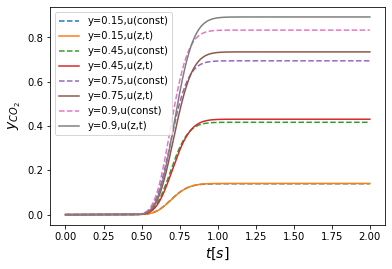

In [11]:
for i,yf in enumerate(yfs):
    yin = y_ins[int(i/2)]
    if i%2 == 0:
        plt.plot(t,yf,'--',label = 'y='+str(yin)+',u(const)')
    else:
        plt.plot(t,yf,'-',label = 'y='+str(yin)+',u(z,t)')

plt.xlabel(r'$t[s]$',size=14)
plt.ylabel(r'$y_{CO_2}$',size=14)
plt.legend()